
# Sokolova (2020) — Methanol formation with revised reaction scheme: Python reproduction

This notebook implements a compact **gas–grain rate-equation** framework to reproduce, *qualitatively*, the calculations in:  
**V. A. Sokolova (2020), _Research in Astronomy and Astrophysics_ 20, 197** — *"Methanol formation chemistry with revised reactions scheme"*.

It follows the paper's setup:
- Two **chemistry variants**: **Model I** (no reverse H-abstraction) and **Model II** (with reverse H-abstraction for HCO and H2CO; barrier for the H + H2CO channel set to 202 K).
- Two **binding-energy sets** for radicals: baseline `Ed(CH2OH)=5080 K`, `Ed(CH3O)=2540 K` and alternative `Ed(CH2OH)=Ed(CH3O)=4400 K`.
- Two **physical models**: (a) static **cold dark cloud**; (b) **collapse** from translucent→dark cloud (**cold stage**) followed by a **warm-up** stage.

> ⚠️ To get **quantitative** agreement with the paper's figures, replace the demo network here with the full MONACO/Vasyunin et al. (2017) network and adopt the **EA1 (low-metal)** and **EA2 (high-metal)** initial abundance sets of Wakelam & Herbst (2008). Hooks are provided below to load such a network from CSV and to plug the initial abundances.

---


## 0) Imports & utilities

In [1]:

import math, numpy as np
import matplotlib.pyplot as plt

# Fallback integrator: RK4 fixed-steps; use SciPy BDF if available
try:
    from scipy.integrate import solve_ivp
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

YR = 365.25*24*3600.0  # seconds per year
KB = 1.380649e-16      # erg/K (cgs)
MH = 1.6735575e-24     # g
AMU = 1.66053906660e-24
PI = math.pi

def arrhenius(alpha, beta, gamma, T):
    """KIDA-like Arrhenius (cm^3 s^-1 for bimolecular gas reactions).
    k(T) = alpha * (T/300)^beta * exp(-gamma/T)
    """
    return alpha * (T/300.0)**beta * np.exp(-gamma/np.maximum(T,1e-6))

def attempt_frequency(E_bind_K):
    """Attempt frequency nu0 ~ 1e12 s^-1 (can scale with Ed)"""
    return 1.0e12

def thermal_velocity(T, mass_amu):
    m = mass_amu * AMU
    return math.sqrt(8.0*KB*T/(PI*m))

def heaviside(x):
    return 1.0*(x>0.0)

def pretty_species(label):
    return label.replace('_','\_')


## 1) Minimal reaction network (demo) & species list

In [2]:

# --- Species (gas) and (grain) ---
# We'll track gas as names like 'CO' and grain-surface as 'gCO' (prefix 'g')
species = [
    'H','H2','CO','HCO','H2CO','CH2OH','CH3O','CH3OH','OH','H2O','O','CH3','CH2'
]
grain_species = ['g'+s for s in ['H','CO','HCO','H2CO','CH2OH','CH3O','CH3OH','OH','O','CH3','CH2']]

all_species = species + grain_species
idx = {s:i for i,s in enumerate(all_species)}

# --- Default masses (amu) for thermal speeds ---
mass = {
    'H':1.0,'H2':2.0, 'CO':28.0, 'HCO':29.0, 'H2CO':30.0, 'CH2OH':31.0, 'CH3O':31.0, 'CH3OH':32.0,
    'OH':17.0, 'H2O':18.0, 'O':16.0, 'CH3':15.0, 'CH2':14.0
}
for s in grain_species:
    mass[s] = mass[s[1:]]

# --- Binding energies (K) for surface species (others default to 1000 K) ---
def make_binding_energy_set(ed_case='baseline'):
    Ed = {s:1000.0 for s in grain_species}
    # Adopt typical values; set CH3O/CH2OH per case; others set plausibly
    # You should replace these with a proper database (e.g., Wakelam et al. 2017) for quantitative work.
    base = {
        'gH':450.0, 'gCO':1150.0, 'gHCO':1600.0, 'gH2CO':2050.0, 'gCH3OH':5530.0,
        'gOH':2850.0, 'gO':1660.0, 'gCH3':1175.0, 'gCH2':1175.0
    }
    for k,v in base.items():
        Ed[k]=v
    if ed_case=='baseline':
        Ed['gCH2OH']=5080.0
        Ed['gCH3O']=2540.0
    elif ed_case=='alt4400':
        Ed['gCH2OH']=4400.0
        Ed['gCH3O']=4400.0
    else:
        raise ValueError("Unknown ed_case")
    return Ed

# Diffusion prefactor (fraction of binding energy)
DIFF_FRAC = 0.35
RD_FRACTION = 0.05  # reactive desorption fraction for exothermic surface reactions (toy value)

# Grain parameters
a_gr = 0.1e-4   # cm (0.1 micron)
n_sites = 1.0e6 # sites per grain
sigma_gr = PI*a_gr*a_gr
site_density = n_sites / (4*PI*a_gr*a_gr)  # sites per cm^2
dust2gas_num = 1.0e-12  # ndust / n_H

# Sticking coefficient for neutrals (toy model)
def sticking_coeff(T):
    return 1.0/(1.0 + 0.04*math.sqrt(T)+ 0.002*T)

# --- Demo gas-phase reactions (very reduced) ---
# Each reaction: ('type', reactants, products, params)
# type: 'gas' (bimolecular), 'ads' (adsorption), 'des' (thermal desorption), 'surf' (LH surface reaction)
# params for gas: alpha,beta,gamma
# params for surf: barrier_K (activation), tunneling flag, etc. (simplified below)
#
# The *demo* network captures the chains in Sokolova (2020) Eqs. (1) and (4)-(18).
# Replace this with full network CSV for a quantitative reproduction.
def demo_network(include_reverse=False):
    gas = []
    surf = []

    # Gas-phase: CH3OH + OH -> CH3O + H2O (Eq. 16)
    gas.append(('gas', ['CH3OH','OH'], ['CH3O','H2O'], dict(alpha=2.0e-11, beta=0.0, gamma=0.0)))

    # Simple H2 formation (placeholder to keep H in check): H + H -> H2
    gas.append(('gas', ['H','H'], ['H2'], dict(alpha=3.0e-17, beta=0.0, gamma=0.0)))

    # Surface hydrogenation chain CO->HCO->H2CO->(CH2OH/CH3O)->CH3OH (Eqs. 1, 11-12)
    # We implement as LH reactions with optional barriers (toy: none or small)
    def sreact(r,p,barrier=0.0):
        surf.append(('surf', ['g'+r[0],'g'+r[1]], ['g'+x for x in p], dict(barrier_K=barrier)))

    # gH + gCO -> gHCO
    sreact(['H','CO'], ['HCO'])
    # gH + gHCO -> gH2CO
    sreact(['H','HCO'], ['H2CO'])
    # gH + gH2CO -> gCH2OH
    sreact(['H','H2CO'], ['CH2OH'])
    # gH + gH2CO -> gCH3O
    sreact(['H','H2CO'], ['CH3O'])
    # gH + gCH2OH -> gCH3OH
    sreact(['H','CH2OH'], ['CH3OH'])
    # gH + gCH3O -> gCH3OH
    sreact(['H','CH3O'], ['CH3OH'])

    # Alternative formation channels discussed in the paper (Eqs. 17-18, 14, 15)
    sreact(['O','CH3'], ['CH3O'])
    sreact(['OH','CH2'], ['CH2OH'])

    # Reverse H-abstraction reactions (Eqs. 2-3) if Model II
    if include_reverse:
        # gH + gH2CO -> gHCO + gH2 (we treat H2 as gas, so put H2 to gas and HCO stays on grain)
        # For simplicity, we model as: gH + gH2CO -> gHCO + H2 (reactive desorption of H2)
        sreact(['H','H2CO'], ['HCO'])  # same reactants; our kinetics machinery will allow competition
        # gH + gHCO -> gCO + H2
        sreact(['H','HCO'], ['CO'])

    return gas, surf


## 2) Physical models (cold cloud; collapse cold stage; warm-up)

In [3]:

class PhysicalModel:
    def __init__(self, name):
        self.name = name

    def state(self, t_yr):
        """Return (T_gas, T_dust, nH, Av) at time (years)."""
        raise NotImplementedError

class ColdDarkCloud(PhysicalModel):
    def __init__(self, T=10.0, nH=1e5, Av=10.0):
        super().__init__('ColdDarkCloud')
        self.T=T; self.nH=nH; self.Av=Av
    def state(self, t_yr):
        return (self.T, self.T, self.nH, self.Av)

class CollapseColdStage(PhysicalModel):
    """Translucent -> dark cloud (free-fall like), over 1e6 yr.
    T: 20 -> 10 K linearly; nH: 3e3 -> 1e7 cm^-3; Av: 2 -> 10 mag (simple interpolation).
    """
    def __init__(self, t_end_yr=1.0e6):
        super().__init__('CollapseColdStage')
        self.t_end=t_end_yr
    def state(self, t_yr):
        x = min(max(t_yr,0.0), self.t_end)/self.t_end
        T = 20.0 + (10.0-20.0)*x
        nH = 3e3 * (1.0 + (1e7/3e3 - 1.0)*x)  # linear in time (toy)
        Av = 2.0 + (10.0-2.0)*x
        return (T, T, nH, Av)

class WarmUpStage(PhysicalModel):
    """Warm-up over 2e5 yr: T: 10 -> 200 K (quadratic), nH, Av held at input constants."""
    def __init__(self, nH_const=1e7, Av_const=10.0, t_span_yr=2.0e5):
        super().__init__('WarmUpStage')
        self.nH=nH_const; self.Av=Av_const; self.t_span=t_span_yr
    def state(self, t_yr):
        x = min(max(t_yr,0.0), self.t_span)/self.t_span
        T = 10.0 + (200.0-10.0)*(x**2)
        return (T, T, self.nH, self.Av)


## 3) Kinetics core: adsorption, desorption, surface diffusion, and ODE builder

In [4]:

class Kinetics:
    def __init__(self, gas_rxns, surf_rxns, Edict, rd_fraction=RD_FRACTION, diff_frac=DIFF_FRAC):
        self.gas_rxns = gas_rxns
        self.surf_rxns = surf_rxns
        self.Ed = Edict
        self.rd_fraction = rd_fraction
        self.diff_frac = diff_frac

    def adsorption_rate(self, species_name, T, nH):
        if species_name=='H2': 
            S = 0.0  # often suppressed; tune as needed
        else:
            S = sticking_coeff(T)
        vth = thermal_velocity(T, mass[species_name])
        n_d = dust2gas_num * nH
        return S * vth * sigma_gr * n_d  # s^-1 per gas particle

    def thermal_desorption_rate(self, gspecies, Tdust):
        Ed = self.Ed.get(gspecies, 1000.0)
        nu0 = attempt_frequency(Ed)
        return nu0 * math.exp(-Ed/max(Tdust,1e-9))  # s^-1

    def surface_reaction_rate(self, gA, gB, Tdust):
        # Simple LH rate: k = (kdiffA + kdiffB) / Nsites, with kdiff = nu0 * exp(-Ediff/T)
        EdA = self.Ed.get(gA, 1000.0); EdB = self.Ed.get(gB, 1000.0)
        EdiffA = self.diff_frac * EdA; EdiffB = self.diff_frac * EdB
        nuA = attempt_frequency(EdA); nuB = attempt_frequency(EdB)
        kdiffA = nuA * math.exp(-EdiffA/max(Tdust,1e-9))
        kdiffB = nuB * math.exp(-EdiffB/max(Tdust,1e-9))
        # Convert to per-pair rate by dividing by number of sites per grain, then per volume via ndust
        n_d = None  # handled outside in ODE assembly
        return (kdiffA + kdiffB) / n_sites  # s^-1 per pair on a grain

def build_ode(phys_model, kin: Kinetics, tgrid_yr, initial_abundances, model_name='ModelI'):
    """Return a function f(t,y) giving dy/dt for species vector y in *fractional abundances* (n_i / n_H).
    We track both gas species and grain species. y is len(all_species).
    """
    gas_rxns = kin.gas_rxns
    surf_rxns = kin.surf_rxns
    Ed = kin.Ed

    # Precompute reactant/product index lists
    gstoich = []
    for r in gas_rxns:
        _, reag, prods, pars = r
        ridx = [idx[s] for s in reag]
        pidx = [idx[s] for s in prods]
        gstoich.append((ridx,pidx,pars))

    sstoich = []
    for r in surf_rxns:
        _, reag, prods, pars = r
        ridx = [idx[s] for s in reag]
        pidx = [idx[s] for s in prods]
        sstoich.append((ridx,pidx,pars))

    def rhs(t_sec, y):
        # Convert t to years to query physical model; phys_model expects years
        t_yr = t_sec / YR
        Tgas, Tdust, nH, Av = phys_model.state(t_yr)
        dydt = np.zeros_like(y)

        # Convenience: extract gas and grain number densities from fractional abundances
        n = y * nH  # cm^-3
        # Adsorption from gas -> grain for tracked g-species
        for s in species:
            gname = 'g'+s
            if gname in idx:
                k_ads = kin.adsorption_rate(s, Tgas, nH)  # s^-1 per gas particle
                flux = k_ads * n[idx[s]]
                dydt[idx[s]] -= flux / nH
                dydt[idx[gname]] += flux / nH

        # Thermal desorption from grain -> gas
        n_d = dust2gas_num * nH
        for g in grain_species:
            base = g[1:]
            if base in idx:
                k_des = kin.thermal_desorption_rate(g, Tdust)  # s^-1
                # total desorption per volume ~ k_des * N_surface_molecules_per_grain * n_d
                # Here, treat g-population as surface population per volume n_g; desorb at k_des
                flux = k_des * n[idx[g]]
                dydt[idx[g]] -= flux / nH
                dydt[idx[base]] += flux / nH

        # Gas-phase bimolecular reactions (mass-action)
        for (ridx_list, pidx_list, pars) in gstoich:
            k = arrhenius(pars['alpha'], pars.get('beta',0.0), pars.get('gamma',0.0), Tgas)
            # For A+A -> ... we divide by 2 to avoid double counting
            if len(ridx_list)==2 and ridx_list[0]==ridx_list[1]:
                rate = k * n[ridx_list[0]]*n[ridx_list[1]] / 2.0
            else:
                rate = k * np.prod([n[i] for i in ridx_list])
            for i in ridx_list:
                dydt[i] -= rate / nH
            for j in pidx_list:
                dydt[j] += rate / nH

        # Surface LH reactions (on-grain). We implement pair-wise encounters proportional to n_gA * n_gB.
        # Reactive desorption: a fraction of products go to gas.
        for (ridx_list, pidx_list, pars) in sstoich:
            gA, gB = ridx_list
            kpair = kin.surface_reaction_rate(all_species[gA], all_species[gB], Tdust)
            # Effective collision term per volume ~ kpair * n_gA * n_gB * n_d (per-grain to per-vol)
            # We fold ndust scaling into kpair by multiplying with n_d here:
            k_eff = kpair * (dust2gas_num * nH)
            rate = k_eff * n[gA]*n[gB]
            # Consume reactants
            dydt[gA] -= rate / nH
            dydt[gB] -= rate / nH
            # Distribute products between grain and gas (reactive desorption fraction)
            for pj in pidx_list:
                # product species name may be grain species; define matching gas if exists
                pname = all_species[pj]
                if pname.startswith('g'):
                    # grain product
                    dydt[pj] += (1.0 - kin.rd_fraction) * rate / nH
                    # reactive desorption to gas counterpart if exists
                    gas_name = pname[1:]
                    if gas_name in idx:
                        dydt[idx[gas_name]] += (kin.rd_fraction) * rate / nH
                else:
                    dydt[pj] += rate / nH

        return dydt

    y0 = np.zeros(len(all_species))
    for s,val in initial_abundances.items():
        if s in idx:
            y0[idx[s]] = val

    return rhs, y0

def integrate(rhs, y0, tspan_yr, nsteps=2000, stiff=False):
    t0, t1 = tspan_yr
    if SCIPY_OK:
        # Use a log-spaced output grid for plotting
        t_eval = np.logspace(np.log10(max(t0,1e-6)), np.log10(t1), 400) * YR
        sol = solve_ivp(rhs, (t0*YR, t1*YR), y0, method='BDF' if stiff else 'RK45',
                        rtol=1e-6, atol=1e-20, t_eval=t_eval, max_step=(t1-t0)*YR/200.0)
        return sol.t/ YR, sol.y.T
    else:
        # Fixed-step RK4 on a log grid of times (works decently for the demo network)
        t_eval = np.logspace(np.log10(max(t0,1e-6)), np.log10(t1), 400)
        y = y0.copy()
        out = []
        t_prev = t_eval[0]
        out.append((t_prev, y.copy()))
        for t in t_eval[1:]:
            # substep into ~50 uniform steps between consecutive t_eval points
            nsub = 50
            for k in range(nsub):
                tt0 = (t_prev + (t - t_prev)*k/nsub) * YR
                h = (t - t_prev)/nsub * YR
                k1 = rhs(tt0, y)
                k2 = rhs(tt0 + 0.5*h, y + 0.5*h*k1)
                k3 = rhs(tt0 + 0.5*h, y + 0.5*h*k2)
                k4 = rhs(tt0 + h, y + h*k3)
                y = y + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
                y = np.clip(y, 0.0, np.inf)
            out.append((t, y.copy()))
            t_prev = t
        tt = np.array([o[0] for o in out])
        yy = np.array([o[1] for o in out])
        return tt, yy


## 4) Initial abundances and run helpers

In [5]:

# Minimal initial abundances (fractional, wrt nH) for the demo.
# Replace these with EA1 / EA2 sets (Wakelam & Herbst 2008) for quantitative reproduction.
EA1_low_metal_demo = {
    'H2': 0.499, 'H': 2e-4, 'He': 0.09,  # He ignored by our reduced network
    'CO': 1.2e-4, 'O': 1.0e-4, 'OH': 1.0e-8, 'CH3':1e-9, 'CH2':1e-9
}
# Ensure species present in our vector; fill missing with 0
def complete_y0(base):
    y0 = {s:0.0 for s in all_species}
    for k,v in base.items():
        if k in idx:
            y0[k]=v
    return y0

def run_scenario(ed_case='baseline', include_reverse=False, phys='cold', warm_up_anchor=None):
    Ed = make_binding_energy_set(ed_case)
    gas_rxns, surf_rxns = demo_network(include_reverse=include_reverse)
    kin = Kinetics(gas_rxns, surf_rxns, Ed)

    if phys=='cold':
        phys_model = ColdDarkCloud(T=10.0, nH=1e5, Av=10.0)
        tspan = (1e2, 1e6)
    elif phys=='collapse_cold':
        phys_model = CollapseColdStage(t_end_yr=1.0e6)
        tspan = (1e2, 1e6)
    elif phys=='warmup':
        # warm-up uses the final nH/Av from collapse; pass via warm_up_anchor
        nHf = warm_up_anchor.get('nH', 1e7)
        Avf = warm_up_anchor.get('Av', 10.0)
        phys_model = WarmUpStage(nH_const=nHf, Av_const=Avf, t_span_yr=2.0e5)
        tspan = (1.0, 2.0e5)  # years
    else:
        raise ValueError("phys must be in {'cold','collapse_cold','warmup'}")

    rhs, y0 = build_ode(phys_model, kin, None, complete_y0(EA1_low_metal_demo),
                        model_name='ModelII' if include_reverse else 'ModelI')
    tt, yy = integrate(rhs, y0, tspan, stiff=True)
    return dict(t_yr=tt, y_frac=yy, Ed=Ed, phys_model=phys_model)

def plot_species(run, labels, title):
    t = run['t_yr']
    y = run['y_frac']
    plt.figure(figsize=(7,5))
    for s, kind in labels:
        series = y[:, idx[s]]
        ls = '-' if not s.startswith('g') else '--'
        plt.plot(t, series, linestyle=ls, label=pretty_species(s))
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Time (yr)'); plt.ylabel('Fractional abundance (n_i / n_H)')
    plt.title(title)
    plt.legend(loc='best'); plt.tight_layout()
    plt.show()


## 5) Generate figure sets analogous to Figs. 1–6 (demo)

KeyError: 'ggCH3OH'

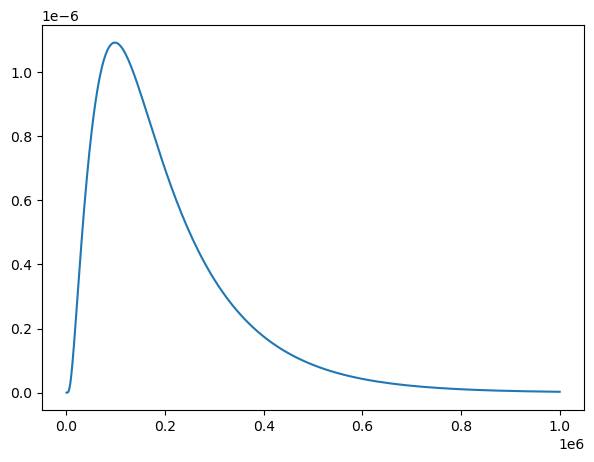

In [6]:

target_species = [
    ('CH3OH','gas'), ('gCH3OH','grain'),
    ('CH3O','gas'), ('gCH3O','grain'),
    ('CH2OH','gas'), ('gCH2OH','grain'),
    ('H2CO','gas'), ('gH2CO','grain'),
    ('HCO','gas'), ('gHCO','grain'),
    ('CO','gas'), ('gCO','grain')
]
labels = [(s if phase=='gas' else 'g'+s, phase) for (s,phase) in target_species]

# Fig. 1 analog (cold cloud, baseline Ed): Model I vs Model II
run1_I  = run_scenario(ed_case='baseline', include_reverse=False, phys='cold')
run1_II = run_scenario(ed_case='baseline', include_reverse=True,  phys='cold')
plot_species(run1_I,  [(l[0],l[1]) for l in labels], 'Cold cloud — Model I (baseline Ed)')
plot_species(run1_II, [(l[0],l[1]) for l in labels], 'Cold cloud — Model II (baseline Ed)')

# Fig. 2 analog (collapse cold stage, baseline Ed)
run2_I  = run_scenario(ed_case='baseline', include_reverse=False, phys='collapse_cold')
run2_II = run_scenario(ed_case='baseline', include_reverse=True,  phys='collapse_cold')
plot_species(run2_I,  [(l[0],l[1]) for l in labels], 'Collapse cold stage — Model I (baseline Ed)')
plot_species(run2_II, [(l[0],l[1]) for l in labels], 'Collapse cold stage — Model II (baseline Ed)')

# Fig. 3 analog (warm-up stage, baseline Ed)
# For simplicity, anchor nH/Av at end of collapse model (toy constants already used)
run3_I  = run_scenario(ed_case='baseline', include_reverse=False, phys='warmup', warm_up_anchor={'nH':1e7,'Av':10.0})
run3_II = run_scenario(ed_case='baseline', include_reverse=True,  phys='warmup', warm_up_anchor={'nH':1e7,'Av':10.0})
plot_species(run3_I,  [(l[0],l[1]) for l in labels], 'Warm-up — Model I (baseline Ed)')
plot_species(run3_II, [(l[0],l[1]) for l in labels], 'Warm-up — Model II (baseline Ed)')

# Fig. 4–6 analogs: switch to Ed(CH2OH)=Ed(CH3O)=4400 K
run4_I  = run_scenario(ed_case='alt4400', include_reverse=False, phys='cold')
run4_II = run_scenario(ed_case='alt4400', include_reverse=True,  phys='cold')
plot_species(run4_I,  [(l[0],l[1]) for l in labels], 'Cold cloud — Model I (Ed=4400/4400 K)')
plot_species(run4_II, [(l[0],l[1]) for l in labels], 'Cold cloud — Model II (Ed=4400/4400 K)')

run5_I  = run_scenario(ed_case='alt4400', include_reverse=False, phys='collapse_cold')
run5_II = run_scenario(ed_case='alt4400', include_reverse=True,  phys='collapse_cold')
plot_species(run5_I,  [(l[0],l[1]) for l in labels], 'Collapse cold stage — Model I (Ed=4400/4400 K)')
plot_species(run5_II, [(l[0],l[1]) for l in labels], 'Collapse cold stage — Model II (Ed=4400/4400 K)')

run6_I  = run_scenario(ed_case='alt4400', include_reverse=False, phys='warmup', warm_up_anchor={'nH':1e7,'Av':10.0})
run6_II = run_scenario(ed_case='alt4400', include_reverse=True,  phys='warmup', warm_up_anchor={'nH':1e7,'Av':10.0})
plot_species(run6_I,  [(l[0],l[1]) for l in labels], 'Warm-up — Model I (Ed=4400/4400 K)')
plot_species(run6_II, [(l[0],l[1]) for l in labels], 'Warm-up — Model II (Ed=4400/4400 K)')


## 6) (Optional) Load a full network from CSV and rerun

In [ ]:

# This cell defines a CSV import format so you can replace the demo network with a proper one.
# Expected CSV columns for gas-phase bimolecular:
#   type, reactants, products, alpha, beta, gamma
# For surface LH reactions:
#   type, reactants, products, barrier_K
# where 'reactants' is 'A+B' and 'products' is 'C+D' with optional 'g' prefixes for grains.

import csv

def load_network_from_csv(csv_path):
    gas, surf = [], []
    with open(csv_path,'r') as f:
        rdr = csv.DictReader(f)
        for row in rdr:
            typ = row['type'].strip()
            reag = [x.strip() for x in row['reactants'].split('+') if x.strip()]
            prods = [x.strip() for x in row['products'].split('+') if x.strip()]
            if typ=='gas':
                pars = dict(alpha=float(row['alpha']), beta=float(row.get('beta',0.0) or 0.0),
                            gamma=float(row.get('gamma',0.0) or 0.0))
                gas.append(('gas', reag, prods, pars))
            elif typ=='surf':
                pars = dict(barrier_K=float(row.get('barrier_K', 0.0) or 0.0))
                # Ensure grain prefixes
                reag = [r if r.startswith('g') else 'g'+r for r in reag]
                prods = [p if p.startswith('g') else 'g'+p for p in prods]
                surf.append(('surf', reag, prods, pars))
            else:
                raise ValueError(f"Unknown type {typ}")
    return gas, surf

print("Network CSV loader defined. Prepare your CSV and rebuild the Kinetics(...) as above.")


## 7) Save & environment info

In [ ]:

import sys, platform
print(f"Python: {sys.version}")
print(f"NumPy: {np.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")
print(f"SciPy available: {SCIPY_OK}")    
